In [2]:
import numpy as np
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal

import gym

from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

In [3]:
def get_net(
        num_in:int,
        num_out:int,
        final_activation,  # e.g. nn.Tanh
        num_hidden_layers:int=5,
        num_neurons_per_hidden_layer:int=64
    ) -> nn.Sequential:

    layers = []

    layers.extend([
        nn.Linear(num_in, num_neurons_per_hidden_layer),
        nn.ReLU(),
    ])

    for _ in range(num_hidden_layers):
        layers.extend([
            nn.Linear(num_neurons_per_hidden_layer, num_neurons_per_hidden_layer),
            nn.ReLU(),
        ])

    layers.append(nn.Linear(num_neurons_per_hidden_layer, num_out))

    if final_activation is not None:
        layers.append(final_activation)

    return nn.Sequential(*layers)

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    def forward(self, x):
        x = self.linear_layer(x)
        return x

In [3]:
class ActorStochastic(nn.Module):
    def __init__(self, s_dim, a_dim, action_boundaries, hidden_dim=256, num_hidden_layers=2):
        super(ActorStochastic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))

        self.f = nn.Sequential(*layers)
        self.mean = nn.Linear(hidden_dim, a_dim)
        self.log_std = nn.Linear(hidden_dim, a_dim)

        self.action_boundaries = action_boundaries

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        out = self.f(state)
        mean = self.mean(out)
        log_std = self.log_std(out)

        #out = torch.tanh(out)
        #log_std = torch.tanh(log_std)
        #std = torch.exp(log_std)
        #noise = torch.normal(0, 1, out.shape[0])
        #action = mean + noise * std
        #dist=torch.distributions.Normal(mean, log_std)
        # log_std = torch.clamp(log_std, -20, 2)
        
        log_std = torch.clamp(log_std, -20, 2)
        
        return mean, log_std

    def sampling(self, state):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mean, std)
        x_t = dist.rsample() #reparametrization trick implemented by pytorch
        action = torch.tanh(x_t) #Bounds the action
        log_prob = dist.log_prob(x_t) # Log probability(/ies if state in batch)
        log_Jacobian = torch.log(1-action**2+1e-10)#.sum(dim=1, keepdim=True)
        #print(log_Jacobian)
        log_prob = (log_prob-log_Jacobian).sum(dim=1, keepdim=True)
        return action, log_prob


In [4]:
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))

        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        out = self.f(x)
        return out

In [5]:
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()

        self.s_dim = s_dim
        self.a_dim = a_dim

        # Two DNNs to mitigate positive bias
        self.Q1 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)
        self.Q2 = QDNN(s_dim, a_dim, hidden_dim, num_hidden_layers)

    def forward(self, state, action):
        q1 = self.Q1(state, action)
        q2 = self.Q2(state, action)
        return q1, q2

In [2]:
class SAC():
    def __init__(self, s_dim, a_dim, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, lambd=0.005, target_upd_inter=1, 
                 buffer_capacity=int(1000), batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.buffer = deque(maxlen=buffer_capacity)
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.lambd = lambd
        self.gamma = gamma
        self.tau = tau
        self.target_upd_inter = target_upd_inter

        self.actor = ActorStochastic(s_dim, a_dim, hidden_dim_actor, num_hidden_layers=num_layer_actor).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.critic = Critic(s_dim, a_dim, hidden_dim_critic, num_hidden_layers=num_layer_critic).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=lr_crit)
        self.critic_target = copy.deepcopy(self.critic).to(device)

    def choose_action(self, state, evaluate=False):
        #print(state.shape)
        if evaluate:
            # Choosing action to give to the environnement and not train the model
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                action, log_prob = self.actor.sampling(state)

            return action.cpu().detach().numpy()[0], log_prob
        
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        # To train actor model and critic
        action, log_prob = self.actor.sampling(state)
        
        return action, log_prob
    
    def critic_train(self, states, actions, rewards, next_states, dones):
        
        with torch.no_grad():
            next_actions, next_log_probs = self.choose_action(next_states, evaluate=False)
            q1_next, q2_next = self.critic_target(next_states, next_actions)
            min_q_next = torch.min(q1_next, q2_next)
            target_q_value = rewards + self.gamma *(torch.ones_like(dones)-dones).unsqueeze(1)*(min_q_next - self.alpha * next_log_probs)
            
        
        #print(target_q_value.shape)
        q1, q2 = self.critic(states, actions)
        #print(q1.shape, q2.shape)    
        critic_loss = F.mse_loss(q1, target_q_value) + F.mse_loss(q2, target_q_value)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        return critic_loss

    
    def actor_train(self, states):
        actions, log_probs = self.choose_action(states, evaluate=False)
        q1_actor, q2_actor = self.critic(states, actions)
        min_q_actor = torch.min(q1_actor, q2_actor)
            
        actor_loss = (self.alpha * log_probs - min_q_actor).mean(dim=0)

        #print(actor_loss)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        return actor_loss

    def train(self, update_interval):
        if len(self.buffer) < self.batch_size:
            return None, None

        for i in range(self.grad_steps):
            
            states, actions, rewards, next_states, dones = self.sample_batch()
            
            # Critic train
            self.critic.train()
            critic_loss= self.critic_train(states, actions, rewards, next_states, dones)

            # Actor train
            self.actor.train()
            actor_loss = self.actor_train(states)

            # Soft update of target networks
            if update_interval % self.target_upd_inter == 0:
                for target_parameters, parameters in zip(self.critic_target.parameters(), self.critic.parameters()):
                    target_parameters.data.copy_(self.tau * parameters.data + (1.0 - self.tau) * target_parameters.data)

        return critic_loss.item(), actor_loss.item()

    def add_elements_to_buffer(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample_batch(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.float32).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        return states, actions, rewards, next_states, dones

## Mountain car continuous

In [4]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Independent
import random
import copy
import matplotlib.pyplot as plt
import random
import torch
from collections import namedtuple, deque

Transition = namedtuple('Transition', 's a r ns d')
Batch = namedtuple('Batch', 's a r ns d')

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv2d):
        nn.init.orthogonal_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)

# Define Linear Layer
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearLayer, self).__init__()
        self.linear_layer = nn.Sequential(nn.Linear(in_features, out_features), nn.ReLU())
    
    def forward(self, x):
        return self.linear_layer(x)

# Define Actor
class ActorStochastic(nn.Module):
    def __init__(self, s_dim, a_dim, action_space, hidden_dim=256, num_hidden_layers=2, device="cpu"):
        super(ActorStochastic, self).__init__()
        self.shared_net   = get_net(num_in=s_dim, num_out=64, final_activation=nn.ReLU())
        
        self.mean = nn.Linear(hidden_dim, a_dim)
        self.log_std = nn.Linear(hidden_dim, a_dim)

        self.action_scale = torch.FloatTensor((action_space.high - action_space.low) / 2.0).to(device)
        self.action_bias = torch.FloatTensor((action_space.high + action_space.low) / 2.0).to(device)
        print(self.action_scale, self.action_bias)

    def forward(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)
        out = self.shared_net(state)
        mean = self.mean(out)
        log_std = self.log_std(out)
        log_std = torch.clamp(log_std, -20, 2)
        return mean, log_std

    def sampling(self, state, repara=False):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        dist = Independent(Normal(loc=mean, scale=std), reinterpreted_batch_ndims=1)
        x_t = dist.rsample() if repara else dist.sample()  # Reparameterization trick
        squashed = torch.tanh(x_t)
        # log_prob = dist.log_prob(x_t)
        # log_prob -= torch.log(self.action_scale*(1 - squashed.pow(2) + 1e-6))
        # log_prob = log_prob.sum(1, keepdim=True)
        #print(dist.log_prob(x_t).shape, x_t.shape, F.softplus(-2*x_t).shape, (2*(np.log(2)-x_t-F.softplus(-2*x_t))).sum(dim=1, keepdim=True).shape)
        #print(squashed.shape, dist.log_prob(x_t).shape, (2*(np.log(2)-x_t-F.softplus(-2*x_t))).sum(dim=1).shape)
        log_prob = dist.log_prob(x_t)-(2*(np.log(2)-x_t-F.softplus(-2*x_t))).sum(dim=1)
        action = self.action_scale*squashed+ self.action_bias
        return action, log_prob.unsqueeze(1)

# Define Q Network
class QDNN(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(QDNN, self).__init__()
        layers = [LinearLayer(s_dim + a_dim, hidden_dim)]
        for _ in range(num_hidden_layers):
            layers.append(LinearLayer(hidden_dim, hidden_dim))
        layers.append(nn.Linear(hidden_dim, 1))
        self.f = nn.Sequential(*layers)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.f(x)


# Define Critic
class Critic(nn.Module):
    def __init__(self, s_dim, a_dim, hidden_dim=256, num_hidden_layers=2):
        super(Critic, self).__init__()
        self.Q = get_net(num_in=s_dim+a_dim, num_out=1, final_activation=None)

    def forward(self, state, action):
        q = self.Q(torch.cat((state, action),dim=1) )
        return q

# Define Custom Replay Buffer
# class ReplayBuffer:
#     def __init__(self, s_dim, a_dim, buffer_capacity=1000000):
#         self.s_dim = s_dim
#         self.a_dim = a_dim
#         self.buffer_capacity = buffer_capacity
#         self.size = 0
#         self.ptr = 0

#         self.states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
#         self.actions = np.zeros((buffer_capacity, a_dim), dtype=np.float32)
#         self.rewards = np.zeros((buffer_capacity, 1), dtype=np.float32)
#         self.next_states = np.zeros((buffer_capacity, s_dim), dtype=np.float32)
#         self.dones = np.zeros((buffer_capacity, 1), dtype=np.float32)

#     def add(self, state, action, reward, next_state, done):
#         self.states[self.ptr] = state
#         self.actions[self.ptr] = action
#         self.rewards[self.ptr] = reward
#         self.next_states[self.ptr] = next_state.squeeze()
#         self.dones[self.ptr] = done

#         self.ptr = (self.ptr + 1) % self.buffer_capacity
#         if self.size < self.buffer_capacity:
#             self.size += 1

#     def sample(self, batch_size):
#         idxs = np.random.randint(0, self.size, size=batch_size)
#         states = torch.FloatTensor(self.states[idxs])
#         actions = torch.FloatTensor(self.actions[idxs])
#         rewards = torch.FloatTensor(self.rewards[idxs])
#         next_states = torch.FloatTensor(self.next_states[idxs])
#         dones = torch.FloatTensor(self.dones[idxs])
#         return states, actions, rewards, next_states, dones

class ReplayBuffer(object):

    def __init__(self, capacity: int):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, transition: Transition) -> None:
        self.memory.appendleft(transition)

    def ready_for(self, batch_size: int) -> bool:
        if len(self.memory) >= batch_size:
            return True
        return False

    def sample(self, batch_size: int) -> Batch:
        batch = random.sample(self.memory, batch_size)
        batch = Batch(*zip(*batch))
        s  = torch.tensor(batch.s, dtype  = torch.float).view(batch_size, -1)
        a  = torch.tensor(batch.a, dtype  = torch.float).view(batch_size, -1)  # continuous, multi-dim action
        r  = torch.tensor(batch.r, dtype  = torch.float).view(batch_size,  1)
        ns = torch.tensor(batch.ns, dtype = torch.float).view(batch_size, -1)
        d  = torch.tensor(batch.d, dtype  = torch.float).view(batch_size,  1)
        return Batch(s, a, r, ns, d)

# Define SAC
class SAC:
    def __init__(self, s_dim, a_dim, action_space, hidden_dim_actor=256, hidden_dim_critic=256, 
                 num_layer_actor=2, num_layer_critic=2, lr_act=3e-4, lr_crit=3e-4, 
                 gamma=0.99, tau=0.005, alpha=0.2, target_upd_inter=1, 
                 buffer_capacity=1000, batch_size=32, grad_steps = 1, device="cpu"):
        
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.device = device
        self.batch_size = batch_size
        self.target_upd_inter = target_upd_inter
        self.grad_steps = grad_steps

        self.alpha = alpha
        self.gamma = gamma
        self.tau = tau

        self.actor = ActorStochastic(s_dim, a_dim, action_space, hidden_dim_actor, num_hidden_layers=num_layer_actor, device=device).apply(init_weights).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=lr_act)

        self.Q1       = Critic(s_dim, a_dim, hidden_dim_critic, num_layer_critic).to(device)
        self.Q1_targ  = Critic(s_dim, a_dim, hidden_dim_critic, num_layer_critic).to(device)
        self.Q1_targ.load_state_dict(self.Q1.state_dict())
        self.Q1_optimizer = optim.Adam(self.Q1.parameters(), lr=lr_crit)

        self.Q2       = Critic(s_dim, a_dim, hidden_dim_critic, num_layer_critic).to(device)
        self.Q2_targ  = Critic(s_dim, a_dim, hidden_dim_critic, num_layer_critic).to(device)
        self.Q2_targ.load_state_dict(self.Q2.state_dict())
        self.Q2_optimizer = optim.Adam(self.Q2.parameters(), lr=lr_crit)
        
        for p in self.Q1_targ.parameters():
            p.requires_grad = False
        for p in self.Q2_targ.parameters():
            p.requires_grad = False

        self.replay_buffer = ReplayBuffer(int(1e6))

    def choose_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        if evaluate:
            with torch.no_grad():
                action, _ = self.actor.sampling(state, repara=False)
        else:
            action, _ = self.actor.sampling(state, repara=False)

        #print(action.shape, mean.shape)
            
        return action.cpu().detach().numpy()[0]
    
    def gradient_clipping(self, model) -> None:
        for param in model.parameters():
            param.grad.data.clamp_(-1, 1)

    def add_to_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self, update_interval):
        # if self.replay_buffer.size < self.batch_size:
        #     return None, None

        actor_l = 0
        critic_l =0
        for _ in range(self.grad_steps):
            # states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
            # states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)
            #print(states.shape, actions.shape, rewards.shape, next_states.shape, dones.shape)
            batch = self.replay_buffer.sample(self.batch_size)
            with torch.no_grad():
                next_actions, next_log_probs = self.actor.sampling(batch.ns.to(self.device))
                #print(self.Q1_targ(next_states, next_actions))
                targets = batch.r.to(self.device) + self.gamma * (1 - batch.d.to(self.device)) * \
                      (torch.min(self.Q1_targ(batch.ns.to(self.device), next_actions), self.Q2_targ(batch.ns.to(self.device), next_actions)) - self.alpha * next_log_probs)
                

            Q1_predictions = self.Q1(batch.s.to(self.device), batch.a.to(self.device))
            Q1_loss = torch.mean((Q1_predictions - targets) ** 2)

            self.Q1_optimizer.zero_grad()
            Q1_loss.backward()
            self.gradient_clipping(self.Q1)
            self.Q1_optimizer.step()

            Q2_predictions = self.Q2(batch.s.to(self.device), batch.a.to(self.device))
            Q2_loss = torch.mean((Q2_predictions - targets) ** 2)

            self.Q2_optimizer.zero_grad()
            Q2_loss.backward()
            self.gradient_clipping(self.Q2)
            self.Q2_optimizer.step()

            for param in self.Q1.parameters():
                param.requires_grad = False
            for param in self.Q2.parameters():
                param.requires_grad = False

            actions_sample, log_probs = self.actor.sampling(batch.s.to(self.device), repara=True)
            actor_loss = - torch.mean(torch.min(self.Q1(batch.s.to(self.device), actions_sample), self.Q2(batch.s.to(self.device), actions_sample)) - self.alpha * log_probs)
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.gradient_clipping(self.actor)
            self.actor_optimizer.step()
            actor_l += actor_loss.item()

            for param in self.Q1.parameters():
                param.requires_grad = True
            for param in self.Q2.parameters():
                param.requires_grad = True

            if update_interval% self.target_upd_inter==0:
                for target_param, param in zip(self.Q1_targ.parameters(), self.Q1.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
                for target_param, param in zip(self.Q2_targ.parameters(), self.Q2.parameters()):
                    target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

        return actor_loss.item(), actor_loss.item()


In [5]:
class ScalingActionWrapper(gym.ActionWrapper):

    """Assumes that actions are symmetric about zero!!!"""

    def __init__(self, env, scaling_factors: np.array):
        super(ScalingActionWrapper, self).__init__(env)
        self.scaling_factors = scaling_factors

    def action(self, action):
        return self.scaling_factors * action

In [235]:
env = gym.make('Pendulum-v1')
# reward_scale = 1  # Example scaling factor
# env = scale_reward(env, reward_scale)
env = ScalingActionWrapper(env, scaling_factors=env.action_space.high)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space,  buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=5, num_layer_critic=5, lr_act=1e-3, lr_crit=1e-3, alpha=0.2, tau=0.005, grad_steps=1, batch_size=128, device="cuda")

score_history = train_SAC(agent, env, 200, training_interval=5, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

tensor([2.], device='cuda:0') tensor([0.], device='cuda:0')
episode 0 score -1008.7 avg score -1008.7
episode 1 score -1553.0 avg score -1280.8
episode 2 score -1362.5 avg score -1308.1
episode 3 score -1528.5 avg score -1363.2
episode 4 score -1751.0 avg score -1440.7
episode 5 score -1653.9 avg score -1476.3
episode 6 score -1294.6 avg score -1450.3
episode 7 score -1865.2 avg score -1502.2
episode 8 score -1500.2 avg score -1502.0
episode 9 score -1414.1 avg score -1493.2
episode 10 score -1766.4 avg score -1568.9
episode 11 score -1628.0 avg score -1576.4
episode 12 score -1775.3 avg score -1617.7


KeyboardInterrupt: 

In [51]:
# # Create the environment
# env = gym.make('MountainCarContinuous-v0')

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hyperparameters
# s_dim = env.observation_space.shape[0]
# a_dim = env.action_space.shape[0]
# action_space = env.action_space
# print(action_space)
# hidden_dim_actor = 64
# hidden_dim_critic = 64
# num_layer_actor = 1
# num_layer_critic = 1
# lr_act = 1e-4
# lr_crit = 1e-4
# gamma = 0.99
# tau = 0.05
# alpha = 0.2
# batch_size = 64
# num_episodes = 100
# update_interval = 1
# target_upd_inter = 1
# buffer_capacity = 10000
# num_warmup = 1000

# # Initialize SAC agent
# agent = SAC(s_dim, a_dim, action_space, hidden_dim_actor, hidden_dim_critic, 
#             num_layer_actor, num_layer_critic, lr_act, lr_crit, gamma, tau, 
#             alpha, buffer_capacity, batch_size, device)


# # Training loop
# episode_rewards = []
# step_warmup = 0
# for episode in range(num_episodes):
#     state, _ = env.reset()
#     episode_reward = 0
#     for t in range(999):
#         action = agent.choose_action(state, evaluate=True)
#         next_state, reward, done, _, _ = env.step([action])
#         agent.add_to_buffer(state, action, reward, next_state, done)
#         state = next_state
#         episode_reward += reward
        
#         if step_warmup>num_warmup:
#             if t % update_interval == 0:
#                 agent.update_parameters(update_interval)
#         else:
#             step_warmup+=1

#         if done:
#             break

#     episode_rewards.append(episode_reward)
#     if (episode + 1) % 5 == 0:
#         print(f"Episode {episode + 1}, Reward: {episode_reward}")

# # Plotting
# plt.plot(episode_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title('SAC on MountainCarContinuous-v0')
# plt.show()

In [252]:
import csv

# Provided data
data = """
episode 0 score -36.2 avg score -36.2
episode 1 score -30.8 avg score -33.5
episode 2 score -31.9 avg score -33.0
episode 3 score -30.4 avg score -32.3
episode 4 score -31.4 avg score -32.1
episode 5 score -31.4 avg score -32.0
episode 6 score -31.0 avg score -31.9
episode 7 score -30.6 avg score -31.7
episode 8 score -32.5 avg score -31.8
episode 9 score -31.2 avg score -31.7
episode 10 score -31.8 avg score -31.3
episode 11 score -31.6 avg score -31.4
episode 12 score -30.0 avg score -31.2
episode 13 score -31.1 avg score -31.3
episode 14 score -31.5 avg score -31.3
episode 15 score -32.3 avg score -31.4
episode 16 score -31.0 avg score -31.4
episode 17 score -31.7 avg score -31.5
episode 18 score -31.7 avg score -31.4
episode 19 score -31.1 avg score -31.4
episode 20 score -32.6 avg score -31.4
episode 21 score -30.1 avg score -31.3
episode 22 score -31.3 avg score -31.4
episode 23 score -32.0 avg score -31.5
episode 24 score -29.5 avg score -31.3
episode 25 score -31.0 avg score -31.2
episode 26 score -31.8 avg score -31.3
episode 27 score -31.4 avg score -31.2
episode 28 score -33.0 avg score -31.4
episode 29 score -30.0 avg score -31.3
episode 30 score -32.8 avg score -31.3
episode 31 score -32.4 avg score -31.5
episode 32 score -31.9 avg score -31.6
episode 33 score -30.4 avg score -31.4
episode 34 score -30.4 avg score -31.5
episode 35 score -30.8 avg score -31.5
episode 36 score -30.6 avg score -31.4
episode 37 score -32.8 avg score -31.5
episode 38 score -30.2 avg score -31.2
episode 39 score -29.4 avg score -31.2
episode 40 score -31.8 avg score -31.1
episode 41 score -29.6 avg score -30.8
episode 42 score -31.0 avg score -30.7
episode 43 score -30.9 avg score -30.7
episode 44 score -31.4 avg score -30.8
episode 45 score -30.9 avg score -30.8
episode 46 score -33.0 avg score -31.1
episode 47 score -33.1 avg score -31.1
episode 48 score -30.9 avg score -31.2
episode 49 score -31.9 avg score -31.4
episode 50 score -30.0 avg score -31.3
episode 51 score -30.4 avg score -31.3
episode 52 score -31.9 avg score -31.4
episode 53 score -29.5 avg score -31.3
episode 54 score -33.6 avg score -31.5
episode 55 score -31.1 avg score -31.5
episode 56 score -32.3 avg score -31.5
episode 57 score -33.1 avg score -31.5
episode 58 score -31.4 avg score -31.5
episode 59 score -32.9 avg score -31.6
episode 60 score -33.0 avg score -31.9
episode 61 score -31.2 avg score -32.0
episode 62 score -31.0 avg score -31.9
episode 63 score -30.8 avg score -32.0
episode 64 score -30.1 avg score -31.7
episode 65 score -29.7 avg score -31.5
episode 66 score -29.7 avg score -31.3
episode 67 score -30.2 avg score -31.0
episode 68 score -31.5 avg score -31.0
episode 69 score -29.4 avg score -30.7
episode 70 score -30.4 avg score -30.4
episode 71 score -31.9 avg score -30.5
episode 72 score -32.1 avg score -30.6
episode 73 score -31.6 avg score -30.7
episode 74 score -33.2 avg score -31.0
episode 75 score -33.5 avg score -31.3
episode 76 score -31.7 avg score -31.5
episode 77 score -28.8 avg score -31.4
episode 78 score -30.9 avg score -31.3
episode 79 score -31.5 avg score -31.5
episode 80 score -30.6 avg score -31.6
episode 81 score -31.6 avg score -31.5
episode 82 score -32.5 avg score -31.6
episode 83 score -31.1 avg score -31.5
episode 84 score -30.5 avg score -31.3
episode 85 score -31.6 avg score -31.1
episode 86 score -31.3 avg score -31.0
episode 87 score -32.1 avg score -31.4
episode 88 score -31.8 avg score -31.5
episode 89 score -32.0 avg score -31.5
episode 90 score -31.7 avg score -31.6
episode 91 score -32.2 avg score -31.7
episode 92 score -29.9 avg score -31.4
episode 93 score -30.3 avg score -31.4
episode 94 score -29.4 avg score -31.2
episode 95 score -30.1 avg score -31.1
episode 96 score -30.4 avg score -31.0
episode 97 score -31.6 avg score -30.9
episode 98 score -30.0 avg score -30.8
episode 99 score -31.2 avg score -30.7
episode 100 score -28.9 avg score -30.4
episode 101 score -31.9 avg score -30.4
episode 102 score -31.3 avg score -30.5
episode 103 score -30.6 avg score -30.6
episode 104 score -31.2 avg score -30.7
episode 105 score -30.7 avg score -30.8
episode 106 score -29.2 avg score -30.7
episode 107 score -31.7 avg score -30.7
episode 108 score -31.1 avg score -30.8
episode 109 score -30.2 avg score -30.7
episode 110 score -31.6 avg score -31.0
episode 111 score -31.9 avg score -30.9
episode 112 score -31.5 avg score -31.0
episode 113 score -30.3 avg score -30.9
episode 114 score -31.6 avg score -31.0
episode 115 score -31.3 avg score -31.0
episode 116 score -32.5 avg score -31.4
episode 117 score -33.3 avg score -31.5
episode 118 score -32.2 avg score -31.6
episode 119 score -30.8 avg score -31.7
episode 120 score -31.6 avg score -31.7
episode 121 score -31.7 avg score -31.7
episode 122 score -32.2 avg score -31.8
episode 123 score -30.9 avg score -31.8
episode 124 score -30.5 avg score -31.7
episode 125 score -29.9 avg score -31.6
episode 126 score -32.7 avg score -31.6
episode 127 score -30.9 avg score -31.4
episode 128 score -30.6 avg score -31.2
episode 129 score -31.3 avg score -31.3
episode 130 score -31.3 avg score -31.2
episode 131 score -32.6 avg score -31.3
episode 132 score -31.4 avg score -31.2
episode 133 score -30.4 avg score -31.2
episode 134 score -32.2 avg score -31.3
episode 135 score -31.5 avg score -31.5
episode 136 score -30.8 avg score -31.3
episode 137 score -31.3 avg score -31.3
episode 138 score -32.2 avg score -31.5
episode 139 score -31.7 avg score -31.5
episode 140 score -30.5 avg score -31.5
episode 141 score -30.8 avg score -31.3
episode 142 score -31.4 avg score -31.3
episode 143 score -31.1 avg score -31.4
episode 144 score -31.0 avg score -31.3
episode 145 score -32.8 avg score -31.4
episode 146 score -30.1 avg score -31.3
episode 147 score -31.0 avg score -31.3
episode 148 score -30.8 avg score -31.1
episode 149 score -30.2 avg score -31.0
episode 150 score -33.0 avg score -31.2
episode 151 score -31.6 avg score -31.3
episode 152 score -29.2 avg score -31.1
episode 153 score -32.6 avg score -31.2
episode 154 score -30.5 avg score -31.2
episode 155 score -30.1 avg score -30.9
episode 156 score -29.9 avg score -30.9
episode 157 score -30.9 avg score -30.9
episode 158 score -31.1 avg score -30.9
episode 159 score -31.0 avg score -31.0
episode 160 score -31.3 avg score -30.8
episode 161 score -30.9 avg score -30.7
episode 162 score -31.1 avg score -30.9
episode 163 score -30.0 avg score -30.7
episode 164 score -29.8 avg score -30.6
episode 165 score -31.5 avg score -30.7
episode 166 score -31.1 avg score -30.9
episode 167 score -30.4 avg score -30.8
episode 168 score -31.7 avg score -30.9
episode 169 score -29.9 avg score -30.8
episode 170 score -29.5 avg score -30.6
episode 171 score -32.7 avg score -30.8
episode 172 score -31.4 avg score -30.8
episode 173 score -30.5 avg score -30.8
episode 174 score -30.1 avg score -30.9
episode 175 score -29.6 avg score -30.7
episode 176 score -29.1 avg score -30.5
episode 177 score -30.0 avg score -30.5
episode 178 score -29.8 avg score -30.3
episode 179 score -31.1 avg score -30.4
episode 180 score -30.4 avg score -30.5
episode 181 score -32.0 avg score -30.4
episode 182 score -30.4 avg score -30.3
episode 183 score -30.7 avg score -30.3
episode 184 score -29.7 avg score -30.3
episode 185 score -29.9 avg score -30.3
episode 186 score -31.9 avg score -30.6
episode 187 score -32.3 avg score -30.8
episode 188 score -30.6 avg score -30.9
episode 189 score -30.7 avg score -30.9
episode 190 score -30.4 avg score -30.9
episode 191 score -31.7 avg score -30.8
episode 192 score -30.5 avg score -30.8
episode 193 score -30.2 avg score -30.8
episode 194 score -30.7 avg score -30.9
episode 195 score -31.7 avg score -31.1
episode 196 score -32.4 avg score -31.1
episode 197 score -30.7 avg score -30.9
episode 198 score -32.8 avg score -31.2
episode 199 score -30.1 avg score -31.1
episode 200 score -31.9 avg score -31.3
episode 201 score -31.7 avg score -31.3
episode 202 score -31.2 avg score -31.3
episode 203 score -31.7 avg score -31.5
episode 204 score -30.3 avg score -31.5
episode 205 score -29.9 avg score -31.3
episode 206 score -29.7 avg score -31.0
episode 207 score -30.2 avg score -31.0
episode 208 score -32.1 avg score -30.9
episode 209 score -30.3 avg score -30.9
episode 210 score -30.2 avg score -30.7
episode 211 score -31.6 avg score -30.7
episode 212 score -32.4 avg score -30.8
episode 213 score -31.2 avg score -30.8
episode 214 score -29.9 avg score -30.8
episode 215 score -31.9 avg score -31.0
episode 216 score -31.1 avg score -31.1
episode 217 score -30.3 avg score -31.1
episode 218 score -32.4 avg score -31.1
episode 219 score -32.2 avg score -31.3
episode 220 score -30.3 avg score -31.3
episode 221 score -31.1 avg score -31.3
episode 222 score -30.7 avg score -31.1
episode 223 score -30.0 avg score -31.0
episode 224 score -31.0 avg score -31.1
episode 225 score -30.3 avg score -30.9
episode 226 score -28.9 avg score -30.7
episode 227 score -29.7 avg score -30.7
episode 228 score -30.0 avg score -30.4
episode 229 score -31.9 avg score -30.4
episode 230 score -32.3 avg score -30.6
episode 231 score -29.7 avg score -30.5
episode 232 score -29.7 avg score -30.4
episode 233 score -30.7 avg score -30.4
episode 234 score -31.1 avg score -30.4
episode 235 score -29.2 avg score -30.3
episode 236 score -29.0 avg score -30.3
episode 237 score -30.8 avg score -30.4
episode 238 score -30.7 avg score -30.5
episode 239 score -31.2 avg score -30.4
episode 240 score -30.9 avg score -30.3
episode 241 score -30.8 avg score -30.4
episode 242 score -31.7 avg score -30.6
episode 243 score -30.2 avg score -30.6
episode 244 score -30.8 avg score -30.5
episode 245 score -31.7 avg score -30.8
episode 246 score -29.7 avg score -30.9
episode 247 score -30.3 avg score -30.8
episode 248 score -32.1 avg score -31.0
episode 249 score -32.8 avg score -31.1
episode 250 score -31.1 avg score -31.1
episode 251 score -30.7 avg score -31.1
episode 252 score -31.9 avg score -31.1
episode 253 score -31.7 avg score -31.3
episode 254 score -29.9 avg score -31.2
episode 255 score -31.2 avg score -31.2
episode 256 score -29.7 avg score -31.2
episode 257 score -30.4 avg score -31.2
episode 258 score -31.4 avg score -31.1
episode 259 score -31.7 avg score -31.0
episode 260 score -31.6 avg score -31.0
episode 261 score -31.2 avg score -31.1
episode 262 score -32.0 avg score -31.1
episode 263 score -29.7 avg score -30.9
episode 264 score -30.5 avg score -30.9
episode 265 score -31.2 avg score -30.9
episode 266 score -31.8 avg score -31.1
episode 267 score -30.0 avg score -31.1
episode 268 score -30.2 avg score -31.0
episode 269 score -32.4 avg score -31.1
episode 270 score -29.8 avg score -30.9
episode 271 score -30.5 avg score -30.8
episode 272 score -31.3 avg score -30.7
episode 273 score -30.8 avg score -30.8
episode 274 score -31.7 avg score -31.0
episode 275 score -29.4 avg score -30.8
episode 276 score -31.4 avg score -30.8
episode 277 score -30.4 avg score -30.8
episode 278 score -30.3 avg score -30.8
episode 279 score -29.9 avg score -30.6
episode 280 score -30.9 avg score -30.7
episode 281 score -30.2 avg score -30.6
episode 282 score -32.2 avg score -30.7
episode 283 score -31.3 avg score -30.8
episode 284 score -30.1 avg score -30.6
episode 285 score -31.3 avg score -30.8
episode 286 score -31.0 avg score -30.8
episode 287 score -31.1 avg score -30.8
episode 288 score -30.7 avg score -30.9
episode 289 score -33.1 avg score -31.2
episode 290 score -32.6 avg score -31.4
episode 291 score -31.6 avg score -31.5
episode 292 score -30.5 avg score -31.3
episode 293 score -30.2 avg score -31.2
episode 294 score -31.1 avg score -31.3
episode 295 score -31.3 avg score -31.3
episode 296 score -31.3 avg score -31.4
episode 297 score -30.6 avg score -31.3
episode 298 score -32.3 avg score -31.5
episode 299 score -30.7 avg score -31.2
"""

# Extract scores from the provided data
lines = data.strip().split('\n')
scores = []

for line in lines:
    parts = line.split()
    score_index = parts.index('score') + 1
    scores.append(parts[score_index])

# Write scores to a CSV file
with open('mountain_sac_64_5_1e-3_02_05_128_1_20upe.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['score'])
    for score in scores:
        writer.writerow([score])

print("Scores have been written to scores.csv")

Scores have been written to scores.csv


In [6]:
### Plot the learning progress
def plot_scores(score_history):
    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    ax.plot(np.arange(1, len(score_history) + 1), score_history, color='green', label='SAC')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

In [7]:
def train_SAC(agent, env, n_games, training_interval=1, update_interval=1, print_num_episodes=10):
    
    n_games = n_games

    best_score = env.reward_range[0]
    score_history = []

    avg_score = 0
    n_steps = 0
    training_interval=training_interval
    update_interval = update_interval
    warmup = 100

    for i in range(n_games):
        state = env.reset()
        done = False
        score = 0
        # while True:
        for _ in range(999):
            # if warmup<n_steps:
            action = agent.choose_action(state, evaluate=True)
            # else :
            #     action = env.action_space.sample()

            next_state, reward, done, _ = env.step(action)
            score += reward
            #print(next_state)
            
            agent.replay_buffer.push(Transition(state, action, reward, next_state, done))
            state = next_state.squeeze()
            update_interval += 1
            n_steps += 1
            if n_steps % training_interval == 0 and agent.replay_buffer.ready_for(agent.batch_size):
                critic_loss, actor_loss = agent.train(update_interval)
            if done:
                break

        score_history.append(score)
        avg_score = np.mean(score_history[-10:])
        if i%print_num_episodes == 0:
            print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score)
            #print(critic_loss, actor_loss)
    
    env.close()

    return score_history

## Mountain car continuous

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


tensor([1.], device='cuda:0') tensor([0.], device='cuda:0')


c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\guill\AppData\Local\Temp\ipykernel_19752\3563533456.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  s  = torch.tensor(batch.s, dtype  = torch.float).view(batch_size, -1)


episode 0 score -36.5 avg score -36.5
episode 1 score -32.6 avg score -34.6
episode 2 score -31.2 avg score -33.5
episode 3 score -27.7 avg score -32.0
episode 4 score -28.1 avg score -31.2
episode 5 score -26.5 avg score -30.5
episode 6 score -26.0 avg score -29.8
episode 7 score -27.7 avg score -29.5
episode 8 score -27.1 avg score -29.3
episode 9 score -26.6 avg score -29.0
episode 10 score -29.6 avg score -28.3
episode 11 score -27.3 avg score -27.8
episode 12 score -26.9 avg score -27.3
episode 13 score -27.1 avg score -27.3
episode 14 score -25.6 avg score -27.0
episode 15 score -27.6 avg score -27.1
episode 16 score -25.9 avg score -27.1
episode 17 score -29.4 avg score -27.3
episode 18 score -25.6 avg score -27.2
episode 19 score -26.6 avg score -27.2
episode 20 score -26.6 avg score -26.9
episode 21 score -27.0 avg score -26.8
episode 22 score -25.7 avg score -26.7
episode 23 score -26.0 avg score -26.6
episode 24 score -27.6 avg score -26.8
episode 25 score -28.4 avg score -2

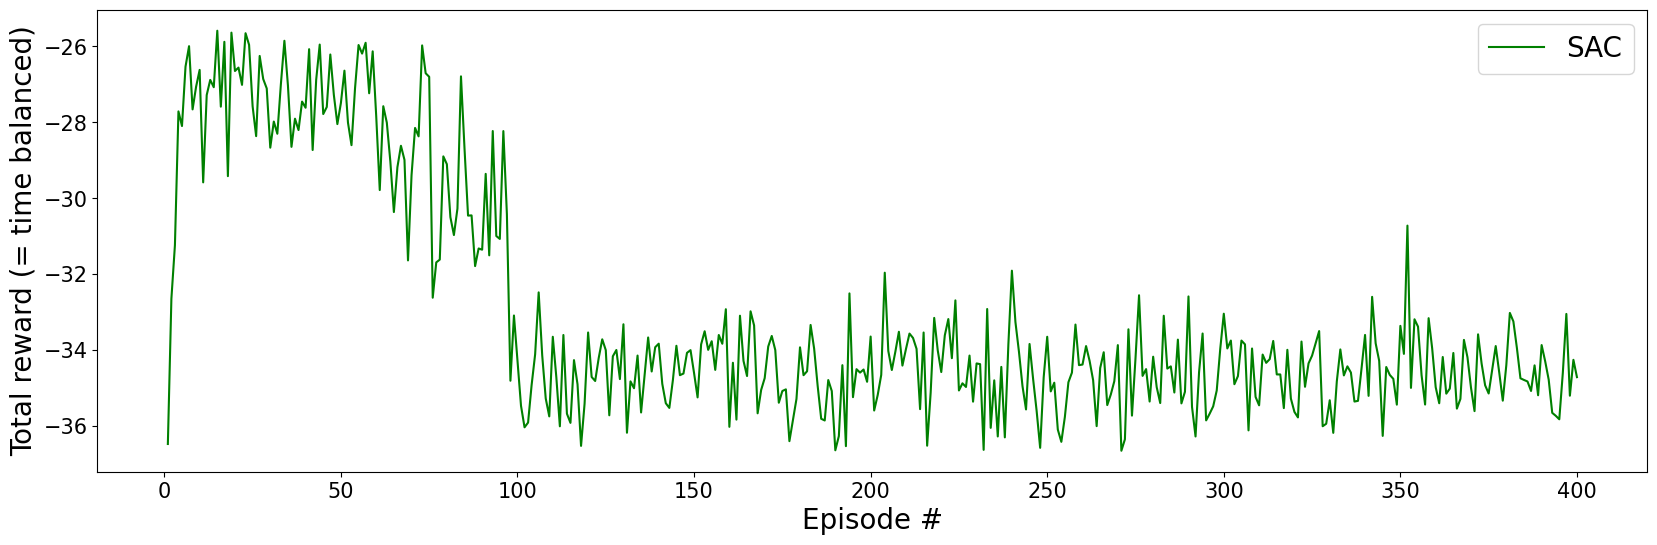

In [8]:
env = gym.make('MountainCarContinuous-v0')

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space, buffer_capacity=int(1e6), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=1e-3, lr_crit=51e-3, alpha=0.1,gamma=0.99,tau=0.05, batch_size=128, grad_steps=1, device="cuda")

score_history = train_SAC(agent, env, 400, training_interval=50, update_interval=1, print_num_episodes=1)
plot_scores(score_history)

In [38]:
agent.actor_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

## Pendulum-v1

In [61]:
def scale_reward(env, reward_scale):
    """
    Scales the rewards of an environment.

    Parameters:
    - env (gym.Env): OpenAI Gym environment.
    - reward_scale (float): Scaling factor for rewards.

    Returns:
    - env_scaled (gym.Env): Scaled OpenAI Gym environment.
    """
    class ScaledRewardEnv(gym.Env):
        def __init__(self, env, reward_scale):
            super(ScaledRewardEnv, self).__init__()
            self.env = env
            self.reward_scale = reward_scale

            self.action_space = env.action_space
            self.observation_space = env.observation_space

        def step(self, action):
            obs, reward, done, info = self.env.step(action)
            return obs, reward * self.reward_scale, done, info

        def reset(self):
            return self.env.reset()

        def render(self, mode='human'):
            return self.env.render(mode)

        def close(self):
            return self.env.close()

        def seed(self, seed=None):
            return self.env.seed(seed)

    env_scaled = ScaledRewardEnv(env, reward_scale)
    return env_scaled

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym

tensor([2.], device='cuda:0') tensor([0.], device='cuda:0')
episode 0 score -1515.3 avg score -1515.3
3.035292148590088 10.344452857971191
episode 1 score -1174.1 avg score -1344.7
14.64004135131836 27.327022552490234
episode 2 score -983.5 avg score -1224.3
2.326014995574951 42.191871643066406
episode 3 score -1235.0 avg score -1227.0
5.7039794921875 56.92253875732422
episode 4 score -868.0 avg score -1155.2
37.61578369140625 64.48893737792969
episode 5 score -1187.9 avg score -1160.6
8.698343276977539 84.44570922851562
episode 6 score -1723.9 avg score -1241.1
149.32479858398438 97.94355010986328
episode 7 score -1266.0 avg score -1244.2
18.23525047302246 118.06604766845703
episode 8 score -1511.8 avg score -1274.0
24.711105346679688 131.60247802734375
episode 9 score -896.5 avg score -1236.2
330.45391845703125 145.87295532226562
episode 10 score -1461.5 avg score -1230.8
213.0397491455078 160.45245361328125
episode 11 score -1137.5 avg score -1227.2
47.75262451171875 169.22700500488

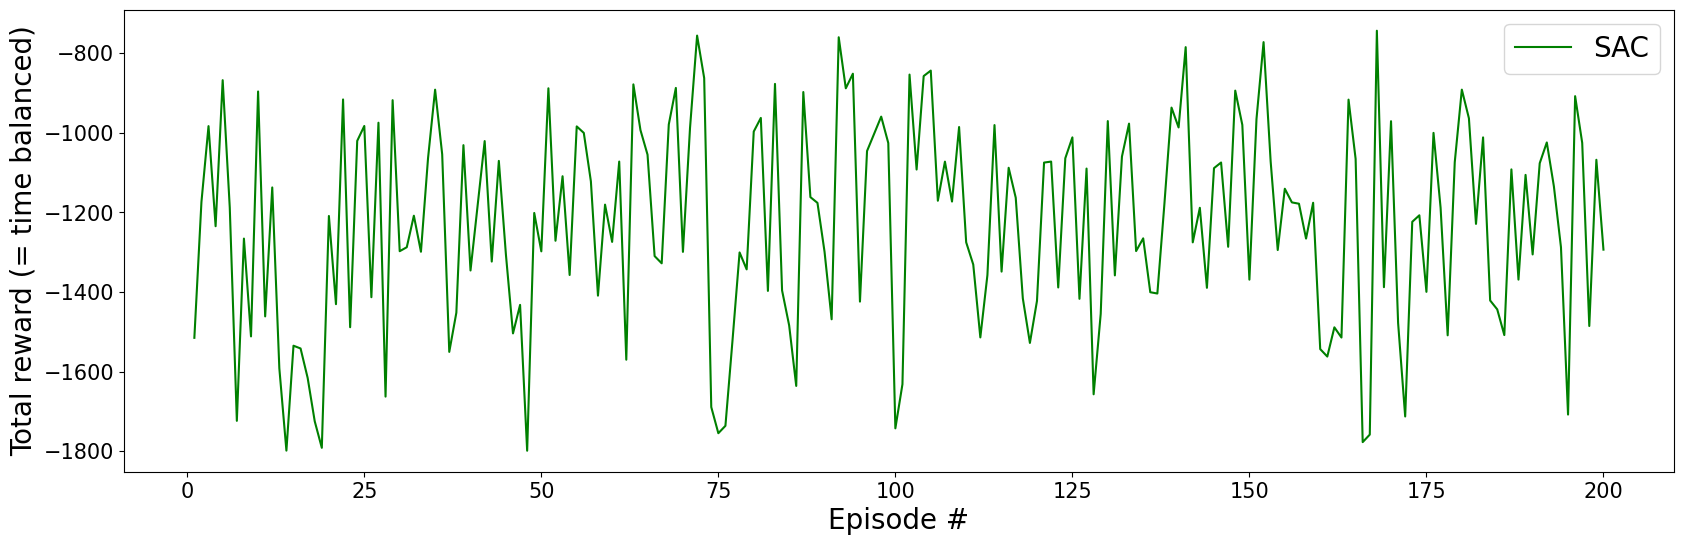

In [67]:
env = gym.make('Pendulum-v1')
reward_scale = 1  # Example scaling factor
env = scale_reward(env, reward_scale)

s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
agent = SAC(s_dim, a_dim, env.action_space,  buffer_capacity=int(1e5), hidden_dim_actor = 64, hidden_dim_critic=64, 
            num_layer_actor=1, num_layer_critic=1, lr_act=3e-4, lr_crit=3e-4, alpha=0.2, tau=0.005, grad_steps=3, batch_size=126, device="cuda")

score_history = train_SAC(agent, env, 200, training_interval=1, update_interval=1, print_num_episodes=1)
plot_scores(score_history)